<center>
<img src="../../img/ods_stickers.jpg">

## Открытый курс по машинному обучению. Сессия № 3
***

## Индивидуальный проект по анализу данных на тему: 
# Прогнозирование оценки отеля путешественником на сайте TripAdvisor

#### Автор материала: Чигин Сергей Олегович (@chigin.sergey)

В данной работе предлагается исследовать датасет, содержащий информацию об отзывах с сайта TripAdvisor. 504 отзыва, сделанные в течение 2015 года, оценивают 21 гостиницу. Все гостиницы расположены на Лас-Вегас-Стрип (примерно семикилометровый участок бульвара Лас-Вегас в округе Кларк в штате Невада, США).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Описание набора данных и признаков

### 1.1 Процесс сбора даннах

Данные были взяты из репозитория UCI: https://archive.ics.uci.edu/ml/datasets/Las+Vegas+Strip

### 1.2 Описание признаков и целевой переменной

Признаки для простоты восприятия можно разбить на три группы: __характеристики пользователя__, __характеристики отзыва__ и __характеристики отеля__. Всего в датасете встречается три типа данных: __binary__ - бинарный, __numeric__ - количественный и __nominal__ - категориальный.  

__Характеристики пользователя__:
* __User country__ - гражданство пользователя, оставившего текущий отзыв (nominal: 48 стран);
* __User continent__ - континент, на котором находится страна пользователя (nominal: 6 континентов);
* __Member years__ - кол-во лет, в течение которых пользователь является зарегестрированным на TripAdvisor.com (numeric: от 0 до 13);
* __Nr. reviews__ - общее кол-во отзывов, сделанных пользователем на сайте (numeric: от 1 до 775);
* __Nr. hotel reviews__ - кол-во отзывов, посвященных отелям (numeric: от 0 до 263);
* __Helpful votes__ - общее кол-во лайков у пользователя (numeric: от 0 до 365).

__Характеристики отзыва__:
* __Review month__ - месяц, во время которого был оставлен отзыв (nominal: 12 месяцев);
* __Review weekday__ - день недели, в течение которого был оставлен отзыв (nominal: 7 дней недели);
* __Period of stay__ - промежуток времени, в который попало пребывание пользователя в отеле (nominal: 'Dec-Feb', 'Mar-May', 'Jun-Aug' и 'Sep-Nov');
* __Traveler type__ - тип путешествия (nominal: 'Couples', 'Families', 'Friends', 'Business' и 'Solo').

__Характеристики отеля__:
* __Hotel name__ - название отеля (nominal: 21 название отеля);
* __Hotel stars__ - кол-во звезд (numeric: от 3 до 5);
* __Nr. rooms__ - кол-во номеров в отеле (numeric: от 188 до 4027);
* __Pool__ - наличие бассейна (binary: yes/no);
* __Gym__ - наличие тренажерного зала (binary: yes/no);
* __Tennis court__ - наличие теннисного корта; (binary: yes/no)
* __Spa__ - наличие спа-салона (binary: yes/no);
* __Casino__ - наличие казино (binary: yes/no);
* __Free internet__ - наличие бесплатного интернета (binary: yes/no).

__Целевая переменная__:
* __Score__ - оценка отеля в текущем отзыве (numeric: от 1 до 5).

### 1.3 Описание решаемой задачи и ее ценность

Определение признаков, оказывающих наибольшее влияние на оценку отеля при составлении отзыва.

Средняя оценка на сайте, сформированная на основе отзывов, имеет большое значение для путешественника при выборе отеля.   Результаты текущего исследования могут быть полезными для менеджеров отелей в работе по улучшению среднего рейтинга, который оказывает влияние на заполняемость отеля. 

Изначально текущая задача является задачей __многоклассовой классификации__. Однако, в процессе исследования (см. п.2.2) задача сведется к __бинарной классификации__. 

## 2. Анализ данных

Выведем несколько первых строк и размер датасета.

In [2]:
df=pd.read_csv('../../data/LasVegasTripAdvisorReviews-Dataset.csv',sep=';')
print('Shape:', df.shape)
df[0:3]

Shape: (504, 20)


,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,February,Saturday


### 2.1 Типы признаков и проверка данных на пропуски

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 20 columns):
User country         504 non-null object
Nr. reviews          504 non-null int64
Nr. hotel reviews    504 non-null int64
Helpful votes        504 non-null int64
Score                504 non-null int64
Period of stay       504 non-null object
Traveler type        504 non-null object
Pool                 504 non-null object
Gym                  504 non-null object
Tennis court         504 non-null object
Spa                  504 non-null object
Casino               504 non-null object
Free internet        504 non-null object
Hotel name           504 non-null object
Hotel stars          504 non-null object
Nr. rooms            504 non-null int64
User continent       504 non-null object
Member years         504 non-null int64
Review month         504 non-null object
Review weekday       504 non-null object
dtypes: int64(6), object(14)
memory usage: 78.8+ KB


Видим, что в датасете нет пропусков - в каждом столбце по 504 наблюдения. __Hotel stars__ при формировании датафрейма определился как категориальный признак (object). Поищем возможную причину.  

In [4]:
np.unique(df['Hotel stars'])

array(['3', '3,5', '4', '4,5', '5'], dtype=object)

В числе возможных значений присутствуют вещественные числа, дробная часть которых записана через запятую. Именно это и является причиной. Сделаем небольшое преобразование и поменяем тип данных на численный.   

In [5]:
df['Hotel stars']=df['Hotel stars'].apply(lambda x: x.replace(',','.')).astype('float64')

Все остальные признаки имеют указанный в описании (п.1.2) тип данных. 

In [6]:
df.get_ftype_counts()

float64:dense     1
int64:dense       6
object:dense     13
dtype: int64

В итоге у нас имеется 7 количественных признаков (6 - целочисленных, 1 - вещественный) и 13 категориальных, среди которых 6 являются бинарными yes/no.

***
_В следующих подпунктах подробно исследована целевая переменная и признаковые группы. Анализ каждой группы последовательно проходит следующие этапы:_ 
* _вывод основных статистических показателей;_ 
* _визуализация распределений;_
* _оценка взаимодействий между признаками внутри группы;_
* _оценка влияния признаков на целевую переменную._

_Таким образом п.2 включает в себя одновременно и первичный анализ данных, и визуальный анализ данных, который по умолчанию должен был идти следующим пунктом. В связи с этим после п.2 сразу же идет п.4, где собраны и прокомментированны все найденные во время анализа зависимости._
***

### 2.2 Анализ целевой переменной

В большинстве случаев очень полезную информацию об отеле несет само содержание отзыва, из которого вытекает поставленная юзером оценка. К сожалению, в текущем датасете эта информация не представлена. Помимо этого у датасета очень небольшой объем - всего 504 объекта. В связи с этим было принято решение немного упростить задачу и свести ее к __бинарной классификации__: 1 - хороший отзыв (оценки 4 и 5), 0 - плохой отзыв (оценки 1, 2 и 3).

Посмотрим на распределение начальной целевой переменной __Score__, а затем на распределение новой __new_score__.

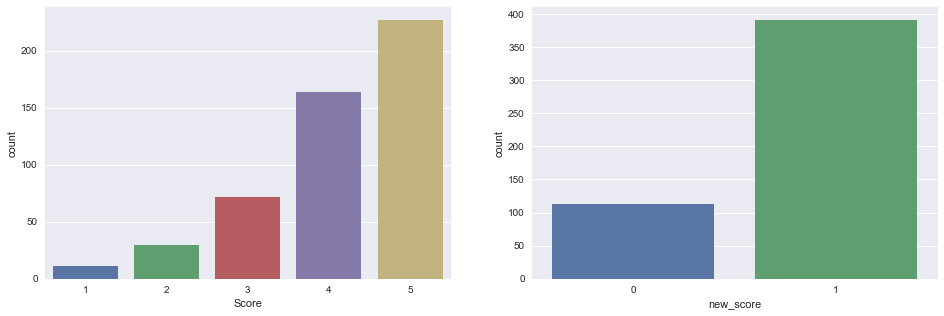

In [7]:
sns.set(style="darkgrid", rc={'figure.figsize':(16,5)})
fig, ax =plt.subplots(1,2)
sns.countplot(df['Score'], ax=ax[0])
df['new_score']=df['Score'].apply(lambda x: 0 if x in [1,2,3] else 1)
sns.countplot(df['new_score'], ax=ax[1]);

In [8]:
df['new_score'].value_counts(normalize=True)

1    0.775794
0    0.224206
Name: new_score, dtype: float64

Видно, что в распределении __new_score__ присутствует дисбаланс. Хороших отзывов примерно в 3.5 раза больше. Будем учитывать это при работе с моделью.

### 2.3 Анализ характеристик пользователя

#### Количественные признаки

Посмотрим на основные статистические параматеры.

In [9]:
df[['User country', 'User continent','Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Member years']].describe()

,Nr. reviews,Nr. hotel reviews,Helpful votes,Member years
count,504.000000,504.000000,504.000000,504.000000
mean,48.130952,16.023810,31.751984,0.767857
std,74.996426,23.957953,48.520783,80.692897
min,1.000000,0.000000,0.000000,-1806.000000
25%,12.000000,5.000000,8.000000,2.000000
50%,23.500000,9.000000,16.000000,4.000000
75%,54.250000,18.000000,35.000000,6.000000
max,775.000000,263.000000,365.000000,13.000000


Сразу же бросается в глаза отрицательное значение __min__ у __Member years__. Проверим, нет ли еще отрицательных значений у этого признака.  

In [10]:
df.loc[df['Member years']<0, 'Member years']

75   -1806
Name: Member years, dtype: int64

Да, оно единственное. Скорее всего была просто допущена ошибка при формировании датасета. Исправим ее путем замены на медианное значение.

In [11]:
df.loc[df['Member years']==df['Member years'].min(), 'Member years']=df['Member years'].median()

Сделаем pairplot для этих признаков. 

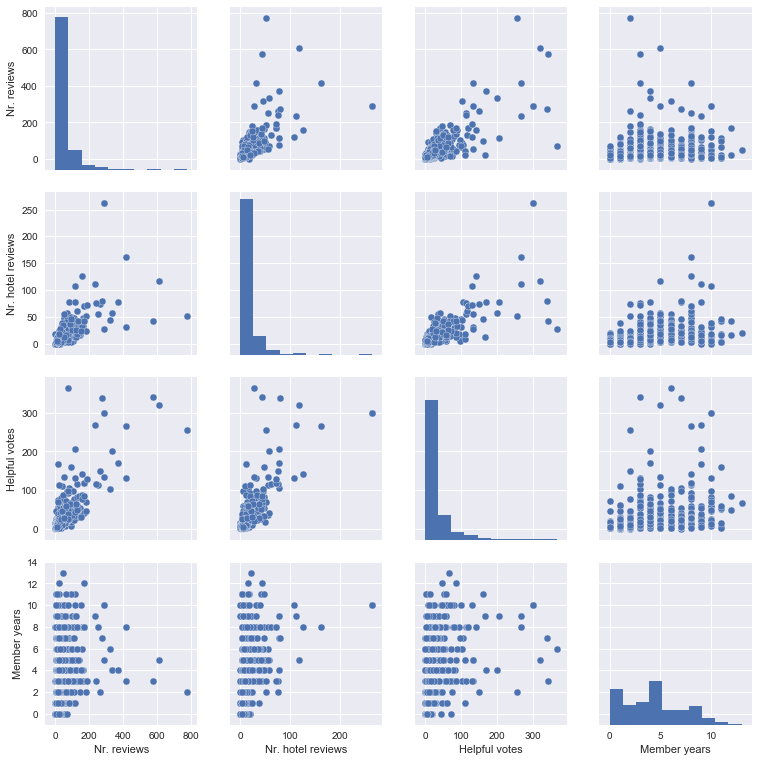

In [12]:
sns.pairplot(df[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Member years']], size=2.7, diag_kind='hist');

У __Nr. reviews, Nr. hotel reviews__ и __Helpful votes__ распределения очень далеки от нормальных, у __Member years__ ситуация получше. По scatter plots видно, что __Member years__ с кем-то из признаков особо никак не взаимодействует. О взаимодействиях между остальными судить довольно сложно - точки слишком кучкуются около начала координат. Добавим к признакам целевую переменную __new_score__ и построим матрицу корреляций. Признаки численные - коэффициенты рассчитываем по Пирсону.  

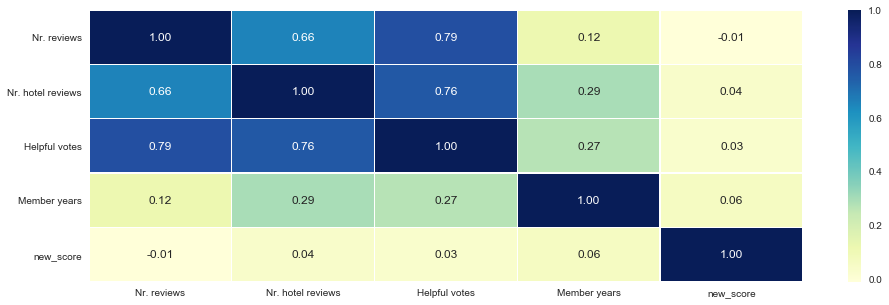

In [13]:
corr_matrix_user=df[['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Member years', 'new_score']].corr(method='pearson')
sns.heatmap(corr_matrix_user, annot=True, fmt=".2f", linewidths=.5, cmap='YlGnBu');

Видим, что у __Nr. reviews, Nr. hotel reviews__ и __Helpful votes__ достаточно высокие коэффициенты. Это нормально. Логично предположить, что у юзера с большим кол-вом рецензий на сайте будет и большое кол-во отзывов непосредственно об отелях. Тоже самое и по лайкам. Их кол-во напрямую зависит от кол-ва рецензий. Целевая переменная ни с одним из признаков не коррелирует. 

#### Категориальные признаки

In [14]:
df[['User country', 'User continent','Nr. reviews', 
    'Nr. hotel reviews', 'Helpful votes', 'Member years']].describe(include='object')

,User country,User continent
count,504,504
unique,48,6
top,USA,North America
freq,217,295


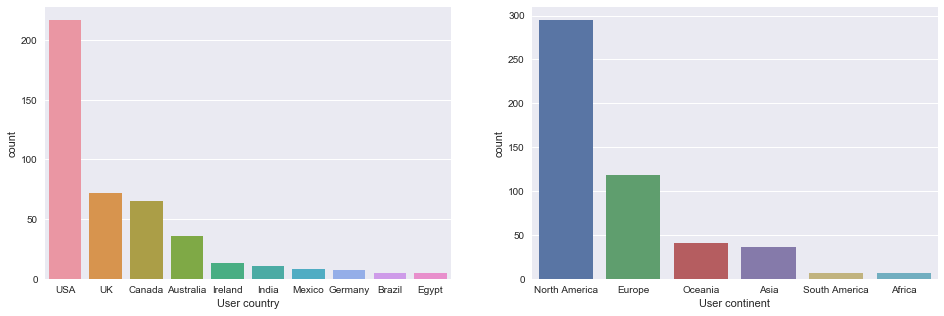

In [15]:
sns.set(style="darkgrid", rc={'figure.figsize':(16,5)})
fig, ax =plt.subplots(1,2)
sns.countplot(df['User continent'], order=df['User continent'].value_counts().index, ax=ax[1])
top10=df[df['User country'].isin(df['User country'].value_counts().head(10).index)]['User country']
sns.countplot(top10, order=top10.value_counts().index, ax=ax[0]);

Для __User country__ выведены 10 самых популярных стран в датасете. Всего же представлено 48 стран. Вычислим какая доля отзывов приходится на топ-10 от общего числа.

In [16]:
print('Share of top 10 countries:', len(top10)/df.shape[0])

Share of top 10 countries: 0.871031746031746


Создадим __User country new__, немного преобразовав __User country__ путем сокращения кол-ва уникальных значений до 11. В них будут входить определенные выше старна топ-10 и новое значение other, объединяющее оставшиеся 38 стран, на чью долю приходится около 13% отзывов от общего числа.

In [17]:
df['User country new']=df['User country'].apply(lambda x: 'Other' if x not in np.unique(top10) else x)

Изобразим распределение хороших и плохих отзывов и по __User continent__, и по __User country new__.

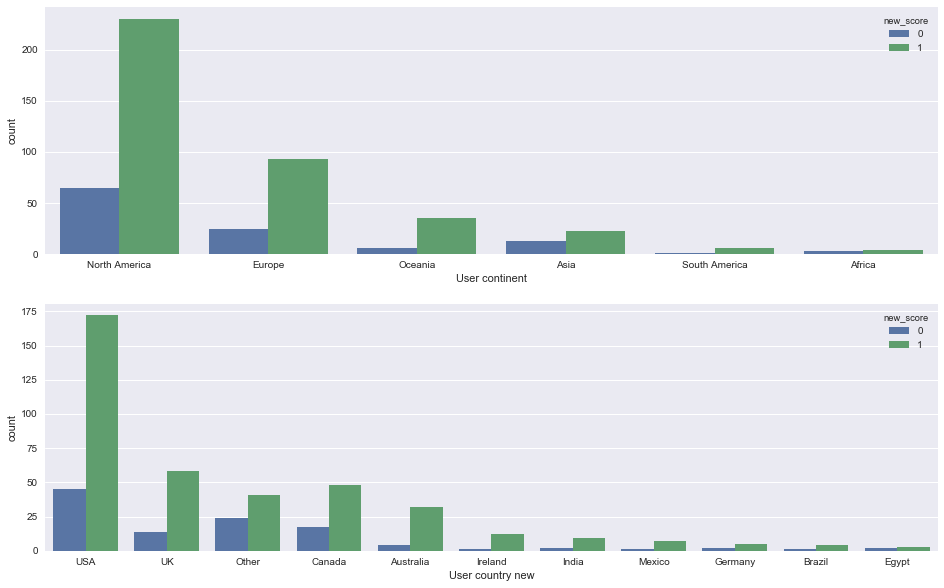

In [18]:
sns.set(style="darkgrid", rc={'figure.figsize':(16,10)})
fig, ax =plt.subplots(2,1)
sns.countplot(x='User continent', hue='new_score', data=df, order=df['User continent'].value_counts().index, ax=ax[0]);
sns.countplot(x='User country new', hue='new_score', data=df, 
              order=df['User country new'].value_counts().index, ax=ax[1]);

Здесь стоит вспомнить зафиксированную в п.2.2 долю отрицательных отзывов в 22,5% от общего кол-ва во всем датасете. Из распределений выше видно, что в абсолютном бол-ве объектов доля негативных отзывов примерно такая же или ниже. Из континентов исключениями являются Азия и Африка, из стран - Канада, Германия, Египет и группа стран, не вошедших в топ-10. У них доля плохих отзывов выше.  

In [19]:
print('Доли плохих отзывов среди континентов в порядке убывания:')
1-df.groupby([df['User continent']])['new_score'].agg([np.mean]).sort_values(by='mean', ascending=True).T

Доли плохих отзывов среди континентов в порядке убывания:


User continent,Africa,Asia,North America,Europe,Oceania,South America
mean,0.428571,0.361111,0.220339,0.211864,0.146341,0.142857


In [20]:
print('Доли плохих отзывов среди стран в порядке убывания:')
1-df.groupby([df['User country new']])['new_score'].agg([np.mean]).sort_values(by='mean', ascending=True).T

Доли плохих отзывов среди стран в порядке убывания:


User country new,Egypt,Other,Germany,Canada,USA,Brazil,UK,India,Mexico,Australia,Ireland
mean,0.4,0.369231,0.285714,0.261538,0.207373,0.2,0.194444,0.181818,0.125,0.111111,0.076923


Но на страны или континенты, которые являются исключениями, приходится довольно небольшое кол-во отзывов всего. Тот факт, что у них высокие доли отрицатальных отзывов нельзя считать четкой зависимостью.    

### 2.4 Анализ характеристик отзыва

Все признаки, характеризующие отзыв, имеют __категориальный__ тип данных. Посмотрим на их общую статистику.    

In [21]:
df[['Period of stay', 'Traveler type', 'Review month', 'Review weekday']].describe(include='object')

,Period of stay,Traveler type,Review month,Review weekday
count,504,504,504,504
unique,4,5,12,7
top,Mar-May,Couples,October,Wednesday
freq,128,214,42,85


__Period of stay__ и __Review month__ определяют временной отрезок, за который у нас имеются данные. Выведем распределение отзывов по ним.

In [22]:
df['Period of stay'].value_counts()

Mar-May    128
Jun-Aug    126
Sep-Nov    126
Dec-Feb    124
Name: Period of stay, dtype: int64

In [23]:
df['Review month'].value_counts()

October      42
March        42
July         42
June         42
September    42
February     42
December     42
January      42
November     42
April        42
May          42
August       42
Name: Review month, dtype: int64

За каждый месяц в 2015 году было взято ровно по 42 отзыва. По сезонам отзывы распределены примерно равномерно. 

Визуализируем распределения оставшихся двух признаков (__Traveler type__ и __Review weekday__).

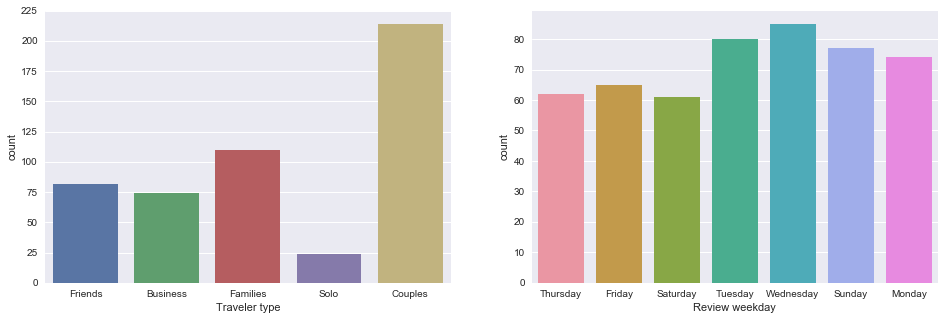

In [24]:
sns.set(style="darkgrid", rc={'figure.figsize':(16,5)})
fig, ax =plt.subplots(1,2)
sns.countplot(df['Traveler type'], ax=ax[0])
sns.countplot(df['Review weekday'], ax=ax[1]);

Посмотрим на то, как меняется кол-во отдыхающих каждого типа от сезона к сезону.

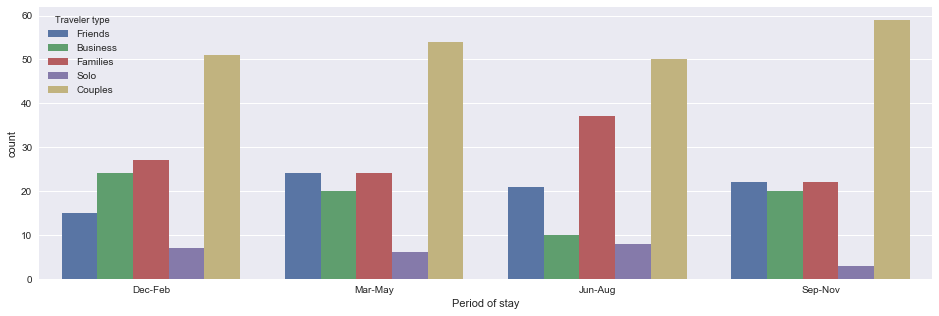

In [25]:
sns.countplot(x='Period of stay', hue='Traveler type', data=df);

Семьи чаще выбираются на отдых летом, в это же время падает кол-во бизнес-трипов. В зимнее время друзья путешествуют вместе реже, чем в остальные сезоны.

Построим похожий countplot для __Review month__ и __Period of stay__. Интересно посмотреть есть ли значительные отставания между написанием отзыва и временем пребывания в отеле.  

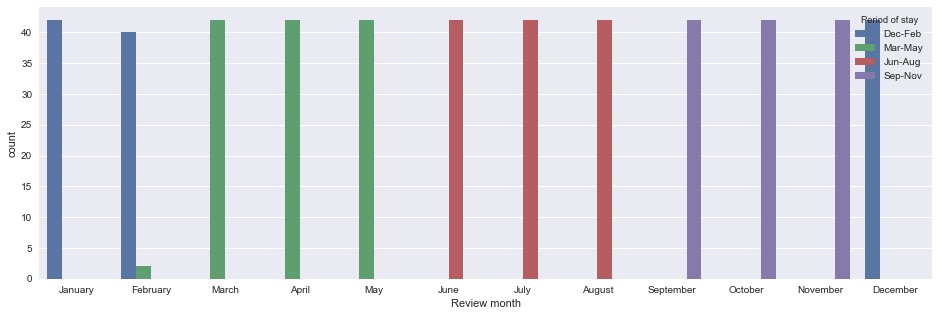

In [26]:
sns.set(style="darkgrid", rc={'figure.figsize':(16,5)})
sns.countplot(x='Review month', hue='Period of stay', data=df);

Очень странная ситуация с февралем. Есть несколько отзывов, которые были написаны в этом месяце, хотя период пребывания в отеле значится __Mar-May__. Как будто отзыв об отеле был составлен еще до самого пребывания там. Выведем отдельно эти отзывы. С остальными месяцами все в порядке.  

In [27]:
df[(df['Review month']=='February') & (df['Period of stay']=='Mar-May')]

,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,...,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday,new_score,User country new
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,...,YES,Circus Circus Hotel & Casino Las Vegas,3.0,3773,North America,2.0,February,Saturday,1,USA
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,...,YES,Circus Circus Hotel & Casino Las Vegas,3.0,3773,Europe,6.0,February,Friday,1,UK


Оба отзыва являются положительными. Скорее всего была просто допущена ошибка при формировании датасета. Чуть выше мы выводили распределение отзывов по сезонам, оно было практически равномерным. Сделаем это еще раз.

In [28]:
df['Period of stay'].value_counts()

Mar-May    128
Jun-Aug    126
Sep-Nov    126
Dec-Feb    124
Name: Period of stay, dtype: int64

Очевидно, что распределение было бы полностью равномерным, если бы не эта ошибка с двумя отзывами. Исправим ее, поменяв у них __Period of stay__ на __Dec-Feb__.

In [29]:
df.loc[(df['Review month']=='February') & (df['Period of stay']=='Mar-May'), 'Period of stay']='Dec-Feb'

Построим countplot с распределениями __new_score__ для __Period of stay__ и __Review month__. 

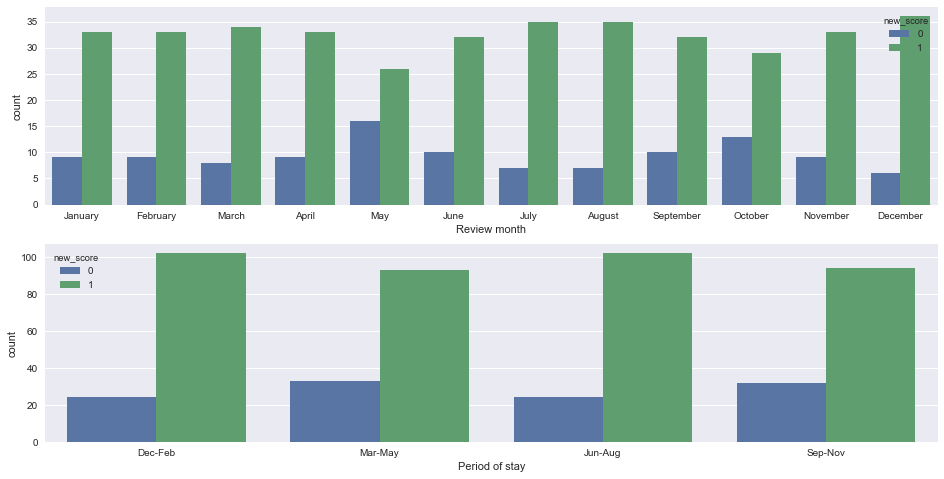

In [30]:
sns.set(style="darkgrid", rc={'figure.figsize':(16,8)})
fig, ax =plt.subplots(2,1)
sns.countplot(x='Review month', hue='new_score', data=df, ax=ax[0]);
sns.countplot(x='Period of stay', hue='new_score', data=df, ax=ax[1]);

Смотря на диаграмму по месяцам, стоит вспомнить, что кол-во отзывов в течение каждого месяца одинаково и равно 42. На май приходится самое большое кол-во плохих отзывов. 

Диаграмма по __Period of stay__ по сути является более грубой версией диаграммы по __Review month__. После исправления ошибки в данных и проверки на отсутствие значительных лагов между пребыванием в отеле и написанием отзыва стало понятно, что эти два признака дублируют друг друга. Разница только во временном отрезке (месяц у __Review month__ и три месяца у __Period of stay__). При предобратке данных признак __Period of stay__ будет необходимо удалить.

Посмотрим на доли плохих отзывов по __Traveler type__ и __Review weekday__.

In [31]:
print('Доли плохих отзывов среди типов путешествий в порядке убывания:')
1-df.groupby([df['Traveler type']])['new_score'].agg([np.mean]).sort_values(by='mean', ascending=True).T

Доли плохих отзывов среди типов путешествий в порядке убывания:


Traveler type,Families,Business,Solo,Couples,Friends
mean,0.3,0.283784,0.25,0.182243,0.170732


Выше всего у __Families__, но на первом месте они с небольшим отрывом. От __Traveler type__ сильно распределение целевой переменной не зависит.

In [32]:
print('Доли плохих отзывов среди дней недели написания отзыва в порядке убывания:')
1-df.groupby([df['Review weekday']])['new_score'].agg([np.mean]).sort_values(by='mean', ascending=True).T

Доли плохих отзывов среди дней недели написания отзыва в порядке убывания:


Review weekday,Wednesday,Tuesday,Sunday,Friday,Thursday,Monday,Saturday
mean,0.294118,0.2625,0.246753,0.215385,0.209677,0.189189,0.114754


Примерно тоже самое можно сказать и про __Review weekday__. Нет какого-то конкретного дня, который аккумулировал на себе прям сильно большую долю плохих отзывов в сравнении с другими днями.

### 2.5 Анализ характеристик отеля

#### Категориальные признаки

In [33]:
df[['Hotel name', 'Pool', 'Gym', 'Tennis court', 'Spa', 'Casino', 'Free internet', 
    'Hotel stars', 'Nr. rooms']].describe(include='object')

,Hotel name,Pool,Gym,Tennis court,Spa,Casino,Free internet
count,504,504,504,504,504,504,504
unique,21,2,2,2,2,2,2
top,Wynn Las Vegas,YES,YES,NO,YES,YES,YES
freq,24,480,480,384,384,456,480


Цифры по __Hotel name__ подтверждают анонсированное в описании распределение - суммарно 504 отзыва о 21 отеле. Посмотрим каким образом распределились отзывы среди этого признака. 

In [34]:
df['Hotel name'].value_counts()

Wynn Las Vegas                                         24
Marriott's Grand Chateau                               24
Tropicana Las Vegas - A Double Tree by Hilton Hotel    24
Trump International Hotel Las Vegas                    24
Monte Carlo Resort&Casino                              24
Encore at wynn Las Vegas                               24
Hilton Grand Vacations on the Boulevard                24
Paris Las Vegas                                        24
Tuscany Las Vegas Suites & Casino                      24
The Westin las Vegas Hotel Casino & Spa                24
Hilton Grand Vacations at the Flamingo                 24
Bellagio Las Vegas                                     24
The Cromwell                                           24
Wyndham Grand Desert                                   24
The Venetian Las Vegas Hotel                           24
Caesars Palace                                         24
Excalibur Hotel & Casino                               24
The Cosmopolit

Они распределены равномерно - по 24 на каждый.

Визуализируем распределения 6-ти бинарных (yes/no) признаков, отвечающих за гостиничные услуги.

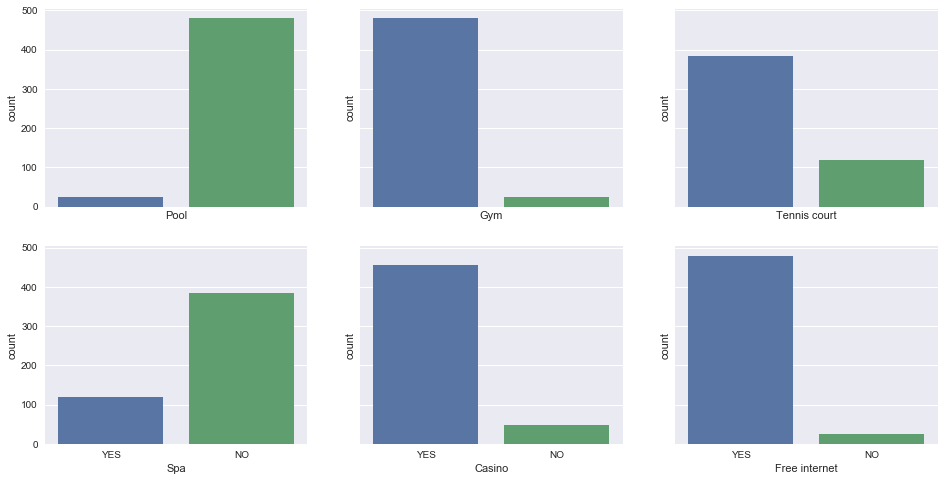

In [35]:
sns.set(style="darkgrid", rc={'figure.figsize':(16,8)})
fig, ax =plt.subplots(nrows=2, ncols=3, sharex='all', sharey='all')
sns.countplot(df['Pool'], ax=ax[0,0])
sns.countplot(df['Gym'], ax=ax[0,1])
sns.countplot(df['Tennis court'], ax=ax[0,2])
sns.countplot(df['Spa'], ax=ax[1,0])
sns.countplot(df['Casino'], ax=ax[1,1])
sns.countplot(df['Free internet'], ax=ax[1,2]);

Бассейн и спа в большинстве отелей отсутствует. Стоит также отметить, что есть отели, пускай их и не много, у которых нет бесплатного интернета.

#### Количественные признаки

In [36]:
df[['Hotel name', 'Pool', 'Gym', 'Tennis court', 'Spa', 'Casino', 'Free internet', 
    'Hotel stars', 'Nr. rooms']].describe()

,Hotel stars,Nr. rooms
count,504.000000,504.000000
mean,4.142857,2196.380952
std,0.774487,1285.476807
min,3.000000,188.000000
25%,3.500000,826.000000
50%,4.000000,2700.000000
75%,5.000000,3025.000000
max,5.000000,4027.000000


Сразу посмотрим на распределение по __Hotel stars__ и выведем кол-во уникальных значений у __Nr. rooms__.

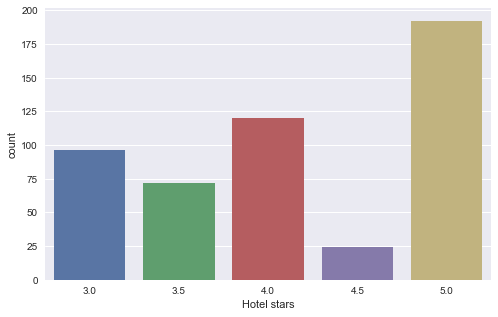

In [37]:
sns.set(style="darkgrid", rc={'figure.figsize':(8,5)})
sns.countplot(df['Hotel stars']);

In [38]:
len(np.unique(df['Nr. rooms']))

21

21 уникальное значение говорит о том, что все гостиницы имеют разные кол-ва номеров. Посмотрим на их распределение.

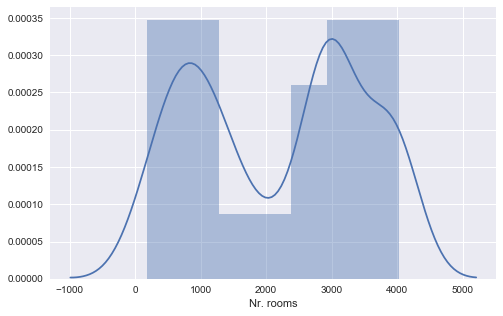

In [39]:
sns.distplot(df['Nr. rooms']);

#### Взаимодействия признаков и влияние на целевую переменную

Перекодируем бинарные признаки yes/no и построим матрицу корреляций.

In [40]:
binary_features=['Pool', 'Gym', 'Tennis court', 'Spa','Casino', 'Free internet']
data_bin=df[binary_features]
data_bin_dum=pd.get_dummies(data_bin)
data_bin_cut=data_bin_dum.iloc[:,1::2]
df_3=pd.concat([data_bin_cut, df[['Hotel stars', 'Nr. rooms', 'new_score']]],axis=1)

Бинарные признаки были разбиты на взаимодополняющие пары (пример: __Pool_YES__ и __Pool_NO__). Из каждой пары были удалены по одному признаку, посколько они не добавляют никакой информации. 

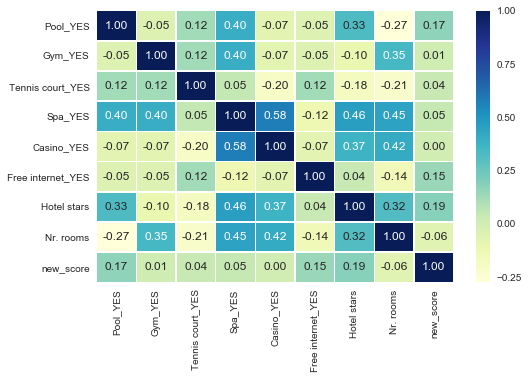

In [41]:
corr_matrix_hotel=df_3.corr()
sns.heatmap(corr_matrix_hotel, annot=True, fmt=".2f", linewidths=.5, cmap='YlGnBu');

__new_score__, пускай коэффициенты и невысокие, но коррелирует с тремя признаками: __Hotel stars__, __Free internet_YES__ и __Pool_YES__.

Так же в матрице наблюдается довольно большое кол-во относительно высоких коэффициентов между признаками. Логика в этом простая. Условно, если есть в отеле казино, то наверняка в нем будет и спа, и спортзал и тд. Но среди признаков нет тех, которые бы дублировали друг друга. 

## 4. Инсайты, найденные зависимости

* Целевая переменая __new_score__ не сбалансирована. Хороших отзывов примерно в 3.5 раза больше, чем плохих;
* Признак __Helpful votes__ сильно коррелирует с __Nr. reviews__ и __Nr. hotel reviews__ (0.79 и 0.76 соответственно) - его можно отбросить;
* __User country__/__User country new__ и __User continent__ несут в себе одинаковую информацию. Один признак распределяет объекты на 48/11 категорий, второй - на 6. При этом оба признака не имеют большого влияния на __new_score__. Первый признак уберем, а второй (__User continent__) оставим. При его кодировании признаковое пространство не будет сильно раздуто;
* Аналогичная ситуация с __Review month__ и __Period of stay__. Оставляем только __Review month__;
* Была обнаружена некая корреляция с __Hotel stars__, __Free internet__ и __Pool__. Логично предположить, что класс отеля и наличие услуг, которые обеспечивают комфорт и удобство клиентов, напрямую влияют на впечатление от пребывания в нем;
* Признак __Hotel name__ содержит только названия отелей и он не несет никакой дополнительной информации о самом отеле, его можно убрать.


## 5. Выбор метрики

Мы решаем задачу бинарной классификации. Допустимые метрики качества в таком случае:
* Accuracy
* Precision
* Recall
* F1-score
* ROC-AUC
* Logistic loss

В нашей задаче отсутствует баланс классов. В этом случае наилучшей метрикой для оценки качества модели будет __ROC-AUC__. Она позволит оценить модель вцелом, не привязываясь к какому-то конкретному порогу.

## 6. Выбор модели

Мои текущие знания моделей на текущий момент не очень обширные. Я в Data Science - новичок. Знаком только с теми, которые были рассмотрены в рамках курса. Среди них следующие алгоритмы подходят для задачи бинарной классификации: 
* KNeighborsClassifier()
* DecisionTreeClassifier()
* RandomForestClassifier()   
* LogisticRegression()
* XGBCClassifier()

Попробуем их с базовыми настройками. Потом отберем те, которые показали лучшие результаты, и продолжим исследование уже только с ними.

## 7. Предобработка данных

Во время анализа данных уже были сделаны небольшие преобраование и исправлены несколько ошибок. В п.4 были перечислены признаки, которые использоваться не будут. Соберем в отдельный датафрейм те, с которыми будем работать, и разобьем их на две группы: количественные и категориальные.

In [42]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, GridSearchCV 

final_df=df[['Nr. reviews', 'Nr. hotel reviews', 'Member years', 'Hotel stars', 'Nr. rooms',
            'User continent', 'Review month', 'Review weekday', 'Traveler type',
                         'Pool', 'Gym', 'Tennis court', 'Spa','Casino', 'Free internet','new_score']]

cat_features=['User continent', 'Review month', 'Review weekday', 'Traveler type',
                         'Pool', 'Gym', 'Tennis court', 'Spa','Casino', 'Free internet']

num_features=['Nr. reviews', 'Nr. hotel reviews', 'Member years', 'Hotel stars', 'Nr. rooms']

Разобьем данные на тренировочную, валидационную и тестовую выборки. Разбивку будем делать с учетом текущего баланса классов.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop('new_score', axis=1), final_df['new_score'], 
                                                    test_size=0.2, random_state=17, stratify=final_df['new_score'])
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=17)

In [44]:
X_train.shape, X_valid.shape, X_test.shape

((403, 15), (50, 15), (51, 15))

Количественные признаки отмасшатабируем с помощью __StandardScaler()__. Категориальные признаки преобразуем с помощью __dummy__ кодирования.

In [45]:
data_scale_train = X_train[num_features]
data_scale_test = X_valid[num_features]
scaler = StandardScaler()
data_scaled_train = scaler.fit_transform(data_scale_train)
data_scaled_valid = scaler.transform(data_scale_test)

In [46]:
data_dum_train = X_train[cat_features]
data_dum_valid = X_valid[cat_features]

data_dum_full=pd.concat([data_dum_train, data_dum_valid], axis=0)
idx_split = data_dum_train.shape[0]

data_dummy_full=pd.get_dummies(data_dum_full)
data_dummy_train = data_dummy_full[:idx_split]
data_dummy_valid = data_dummy_full[idx_split:]

Объедим уже преобразованные признаки и приведем их к виду разряженных матриц.

In [47]:
from scipy.sparse import csr_matrix
X_train_sparse = csr_matrix(hstack([data_scaled_train, data_dummy_train]))

X_valid_sparse = csr_matrix(hstack([data_scaled_valid, data_dummy_valid])) 

## 8. Кросс-валидация и настройка гиперпараметров модели

### 8-1. Кросс-валидация

На кросс-валидации будем разбивать тренировочную выборку на 5 фолдов с учетом баланса классов.

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

models = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state = 17),
    RandomForestClassifier(n_estimators=100, random_state = 17), 
    XGBClassifier(random_state = 17),
    LogisticRegression(random_state = 17)
    
]

for model in models:
    model.fit(X_train_sparse, y_train)
    score = np.mean(cross_val_score(model, X_train_sparse, y_train, cv=skf, scoring='roc_auc'))
    print('roc auc:', score)
    print(model)
    print()

roc auc: 0.5620384593502873
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

roc auc: 0.5659754224270352
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

roc auc: 0.5629245605052057
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=F

Вцелом скор довольно невысокий у всех, но лучший у __LogisticRegression__. Оставляем ее и попробуем улучшить как-то качество с помощью работы над признаковым пространством.

## 9. Создание новых признаков и описание этого процесса

В данных преимущественно категориальные признаки. Мощной техникой для работы в этом случае является учет попарных взаимодействий признаков (feature interactions). Построим попарные взаимодействия всех категориальных признаков.

### 9.1 Попарные взаимодействия признаков

In [49]:
train_interact = X_train[['User continent', 'Review month', 'Review weekday', 'Traveler type','Pool', 
                       'Gym', 'Tennis court', 'Spa','Casino', 'Free internet']]

cat_features = train_interact.columns[train_interact.dtypes == 'object']
for i, col1 in enumerate(cat_features):
    for j, col2 in enumerate(cat_features[i + 1:]):
        train_interact[col1 + '_' + col2] = train_interact[col1] + '_' + train_interact[col2] 

In [50]:
train_interact.head()

,User continent,Review month,Review weekday,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,...,Gym_Tennis court,Gym_Spa,Gym_Casino,Gym_Free internet,Tennis court_Spa,Tennis court_Casino,Tennis court_Free internet,Spa_Casino,Spa_Free internet,Casino_Free internet
194,North America,February,Saturday,Couples,YES,YES,YES,YES,YES,YES,...,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES
93,Oceania,November,Friday,Families,YES,YES,YES,YES,YES,YES,...,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES,YES_YES
381,North America,November,Sunday,Business,YES,YES,NO,NO,NO,YES,...,YES_NO,YES_NO,YES_NO,YES_YES,NO_NO,NO_NO,NO_YES,NO_NO,NO_YES,NO_YES
127,North America,April,Saturday,Couples,YES,YES,NO,YES,YES,YES,...,YES_NO,YES_YES,YES_YES,YES_YES,NO_YES,NO_YES,NO_YES,YES_YES,YES_YES,YES_YES
55,Africa,April,Tuesday,Business,YES,YES,NO,YES,YES,NO,...,YES_NO,YES_YES,YES_YES,YES_NO,NO_YES,NO_YES,NO_NO,YES_YES,YES_NO,YES_NO


In [51]:
dummy_train_interact = pd.get_dummies(train_interact)
X_train_interact_sparse = csr_matrix(hstack([data_scaled_train, dummy_train_interact]))
X_train_interact_sparse.shape

(403, 735)

Ох, после объединения с 5-ю отскалированными количественными получилось 735 признаков - это больше чем тренировочных объектов. Вряд ли это приведет к каким-то улучшениями, но все равно попробуем.

In [52]:
model=LogisticRegression(random_state = 17)

model.fit(X_train_sparse, y_train)
score = np.mean(cross_val_score(model, X_train_interact_sparse, y_train, cv=skf, scoring='roc_auc'))
print('roc auc:', score)
print(model)
print()

roc auc: 0.546384479717813
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)



Да, скор упал. Но у нас есть еще 5 количественных признаков, двое из которых имели распределения с сильным скосом вправо.  

### 9.2 Логарифмирование количественных признаков

Посмотрим как изменятся распределения __Nr. reviews__ и __Nr. hotel reviews__ после логарифмирования.

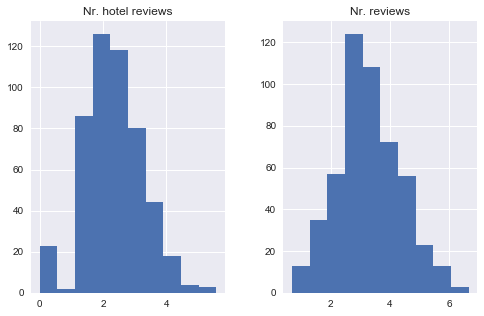

In [53]:
np.log(final_df[['Nr. reviews', 'Nr. hotel reviews']]+1).hist();

Стали очень похожи на нормальные распределения. Попробуем посмотреть на скор с прологарифмированными __Nr. reviews__ и __Nr. hotel reviews__.

In [54]:
X_train[['Nr. reviews', 'Nr. hotel reviews']]=np.log(X_train[['Nr. reviews', 'Nr. hotel reviews']]+1)
X_valid[['Nr. reviews', 'Nr. hotel reviews']]=np.log(X_valid[['Nr. reviews', 'Nr. hotel reviews']]+1)

data_scale_train = X_train[num_features]
data_scale_valid = X_valid[num_features]
scaler = StandardScaler()
data_scaled_train = scaler.fit_transform(data_scale_train)
data_scaled_valid = scaler.transform(data_scale_valid)

data_dum_train = X_train[cat_features]
data_dum_valid = X_valid[cat_features]

data_dum_full=pd.concat([data_dum_train, data_dum_valid], axis=0)
idx_split = data_dum_train.shape[0]

data_dummy_full=pd.get_dummies(data_dum_full)
data_dummy_train = data_dummy_full[:idx_split]
data_dummy_valid = data_dummy_full[idx_split:]

In [55]:
X_train_sparse = csr_matrix(hstack([data_scaled_train, data_dummy_train]))

X_valid_sparse = csr_matrix(hstack([data_scaled_valid, data_dummy_valid])) 

In [56]:
model.fit(X_train_sparse, y_train)
score = np.mean(cross_val_score(model, X_train_sparse, y_train, cv=skf, scoring='roc_auc'))
print('roc auc:', score)
print(model)
print()

roc auc: 0.6255817261193606
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)



Есть небольшие улучшения, скор подрос. Попробуем понастраивать гиперпараметры.

## 8. Кросс-валидация и настройка гиперпараметров модели

### 8-2. Настройка гиперпараметров модели

У LogisticRegression() будем настраивать следующий параметр:
* С - обратное значение коэффициента регуляризации.

In [57]:
params={'C': np.logspace(-3, 1, 10)}

model = LogisticRegression(random_state=17)

lr_grid = GridSearchCV(model, param_grid=params, cv=skf, scoring='roc_auc', verbose=True, n_jobs=-1)
lr_grid.fit(X_train_sparse,y_train)
print(lr_grid.best_score_)
print(lr_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.64495164911398
{'C': 0.05994842503189409}


[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished


Проверим лучшую модель на валидационной выборке.

In [58]:
logit=lr_grid.best_estimator_

logit.fit(X_train_sparse, y_train)
logit_valid_pred = logit.predict_proba(X_valid_sparse)[:, 1]
roc_auc_score(y_valid, logit_valid_pred)

0.6074561403508771

In [59]:
logit

LogisticRegression(C=0.05994842503189409, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## 10. Построение кривых валидации и обучения

Сначала посмотрим на кривые обучения.

In [60]:
from sklearn.model_selection import learning_curve

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

def plot_learning_curve():
    train_sizes = np.linspace(0.05, 1, 20)
    
    N_train, val_train, val_test = learning_curve(logit, X_train_sparse, y_train, train_sizes=train_sizes, cv=skf,
                                                  scoring='roc_auc')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training examples'); 
    plt.ylabel('ROC-AUC')
    plt.legend()

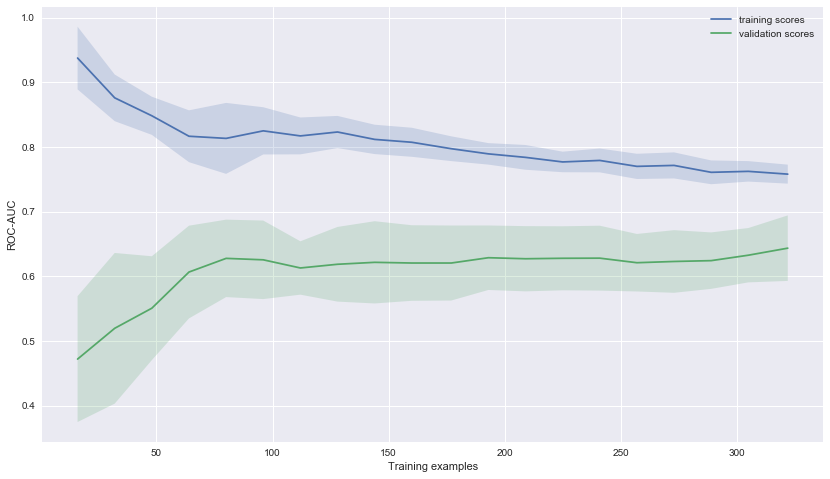

In [61]:
plt.figure(figsize=(14, 8))
plot_learning_curve()

В принципе, наблюдается хорошая тенденция – кривые постепенно сходятся. Можно предположить, что при дальнейшем движении направо качество на валидации можно будет повысить. Переходим к кривым валидации. 

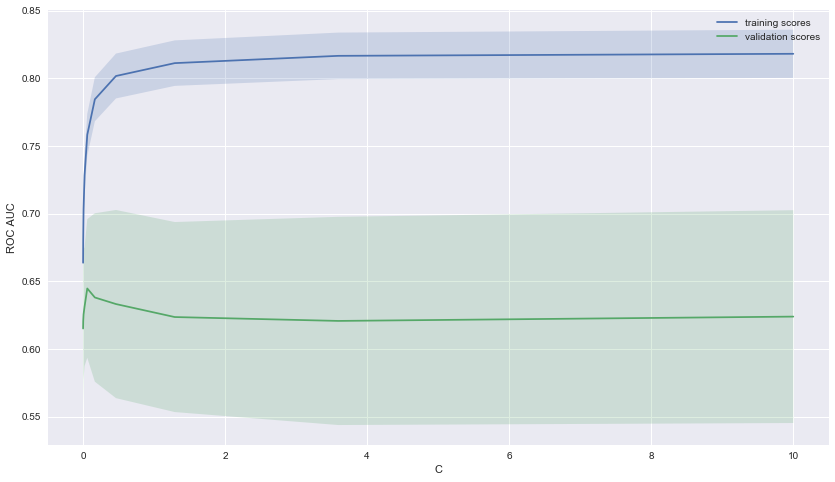

In [62]:
from sklearn.model_selection import validation_curve

C_range=np.logspace(-3, 1, 10)

val_train, val_test = validation_curve(model, X_train_sparse, y_train, param_name='C', 
                                       param_range=C_range, cv=skf, scoring='roc_auc')

plt.figure(figsize=(14, 8))
plot_with_err(C_range, val_train, label='training scores')
plot_with_err(C_range, val_test, label='validation scores')
plt.xlabel('C')
plt.ylabel('ROC AUC')
plt.legend();

У С есть явный пик. При увеличении параметра скор падает, но не резко и не значительно.

## 11. Прогноз на тестовой выборке

Объедими тренировочную выборку с валидационной и обучим на них модель. Затем проверим ее качество на тестовой выборке.

In [63]:
X_train = X_train.append(X_valid)
y_train = y_train.append(y_valid)

In [64]:
X_test[['Nr. reviews', 'Nr. hotel reviews']]=np.log(X_test[['Nr. reviews', 'Nr. hotel reviews']]+1)

data_scale_train = X_train[num_features]
data_scale_test = X_test[num_features]
scaler = StandardScaler()
data_scaled_train = scaler.fit_transform(data_scale_train)
data_scaled_test = scaler.transform(data_scale_test)

data_dum_train = X_train[cat_features]
data_dum_test = X_test[cat_features]

data_dum_full=pd.concat([data_dum_train, data_dum_test], axis=0)
idx_split = data_dum_train.shape[0]

data_dummy_full=pd.get_dummies(data_dum_full)
data_dummy_train = data_dummy_full[:idx_split]
data_dummy_test = data_dummy_full[idx_split:]

In [65]:
X_train_sparse = csr_matrix(hstack([data_scaled_train, data_dummy_train]))

X_test_sparse = csr_matrix(hstack([data_scaled_test, data_dummy_test])) 

In [66]:
logit.fit(X_train_sparse, y_train)
logit_test_pred = logit.predict_proba(X_test_sparse)[:, 1]
roc_auc_score(y_test, logit_test_pred)

0.7318181818181818

Результат на тестовой выборке лучше. Думаю, что причина кроется в большем кол-ве данных, на которых модель обучалась. Мы словно проверили на практике предположение, сделанное по кривым обучения в п.10. Как раз объединив тренировочную выборку с валидационной, мы сместились немного вправо. 

## 12. Выводы

Изначально целью иследования было определение факторов, которые сильнее всего оказывают влияние на оценку. Давайте посмотрим на веса модели.

In [67]:
names=data_scale_train.columns.append(data_dummy_full.columns)

def getCoefficients(model):
    """
    Возвращает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_[0], names)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)    
    

def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    coefs = getCoefficients(model)
    
    plt.figure(figsize=(20, 10))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

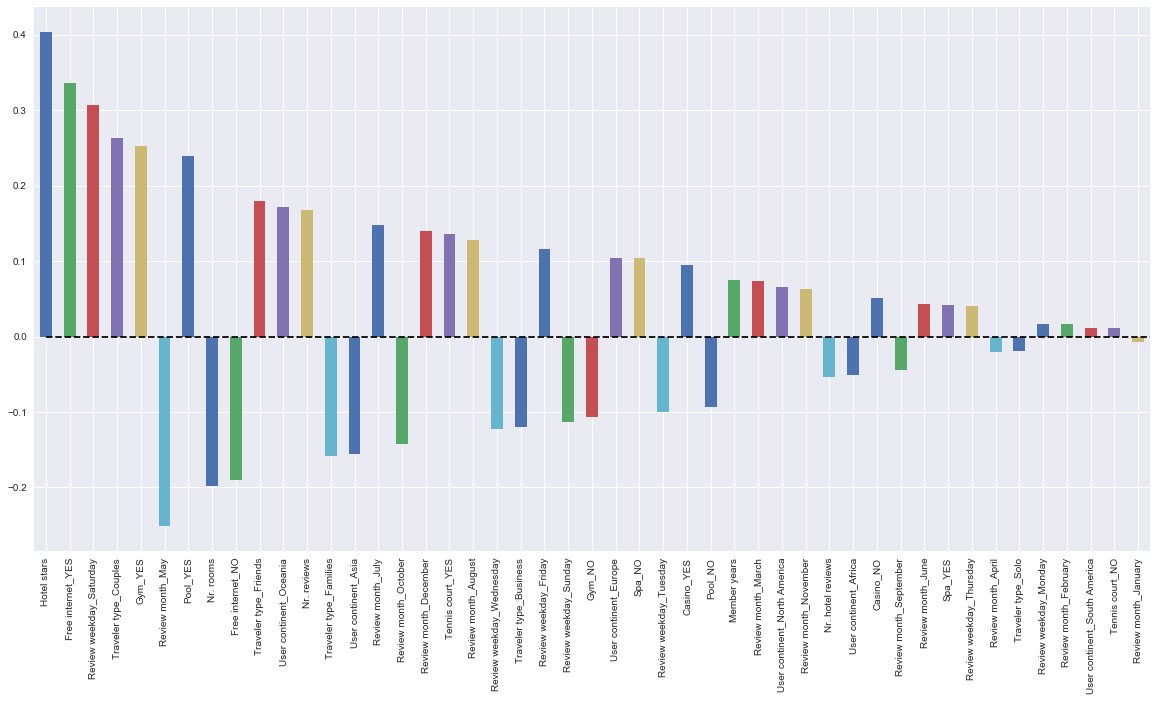

In [68]:
plotCoefficients(logit)

Результаты вряд ли можно назвать удивительными. Сильнее всего влияет на оценку кол-во звезд у отеля и наличи бесплатного интернета. 

На данный момент, качество модели не очень высокое, но убежден, что у исследования есть потенциал. Следующие пункты, наверняка помогли бы его улучшить: 
* увеличение объема данных (здесь речь непосредственно о кол-ве объектов в датасете);
* добавление новых признаков с полезной информацией (текст отзыва, год постройки отеля, численность обслуживающего персонала, языки, на которых говорит персонал и тд);
* охват больших территорий, на которых расположены отели (разные города, разные страны).